In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Measurement table

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

# Get a better understanding of the dataset
# Check out lesson 10.3 "03-Stu_Dates" for a good example

# Get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Identyfy the column names and data types in the 'measurement' table
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [12]:
# Display a sample of the data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The latest date is: {latest_date}")

# One year prior
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The date one year before that was: {query_date}")

# Date from that range
last_year_rainfall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()



# Save the query results as a Pandas DataFrame
last_year_rainfall_df = pd.DataFrame(last_year_rainfall, columns=['date', 'prcp'])

# Sort by date
last_year_rainfall_df.sort_values(by=['date'])
last_year_rainfall_df



The latest date is: ('2017-08-23',)
The date one year before that was: 2016-08-23


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

# Create the dataframe of total rainfall by day
last_year_rainfall_df.dropna(subset=['prcp'], inplace=True)
last_year_rainfall_grouped = last_year_rainfall_df.groupby(["date"])
daily_totals = last_year_rainfall_grouped["prcp"].sum()

# Create the Pandas dataframe for plotting
rainfall_pd = pd.DataFrame({
    "Prcp": daily_totals
})

rainfall_pd

,Prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


([], <a list of 0 Text xticklabel objects>)

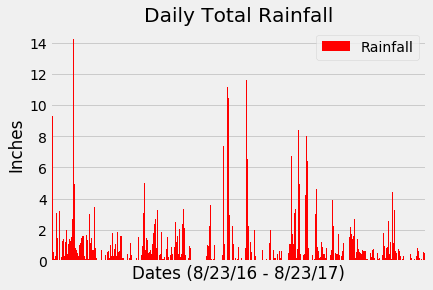

In [52]:
group_keys = list(last_year_rainfall_grouped.groups.keys())
rainfall_bar_chart = pd.DataFrame({'x_axis': group_keys, 'Rainfall': daily_totals})
rainfall_bar_chart.plot.bar(x='x_axis', y='Rainfall', color='red', width=1, rot=90);

# Adding axis labels
plt.title("Daily Total Rainfall")
plt.xlabel("""Dates (8/23/16 - 8/23/17)""")
plt.ylabel("Inches")
plt.xticks([],[])

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_rainfall_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Text(0, 0.5, 'Inches')

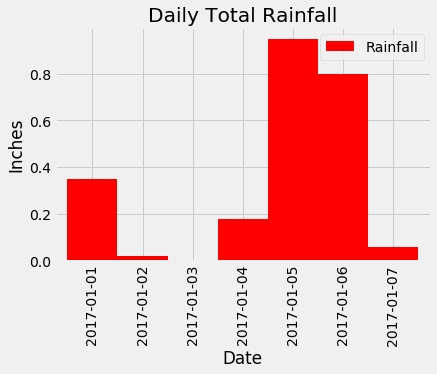

In [54]:
# Perform a query to retrieve precipitation scores for a 10 day vacation period
vacation_filter = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= "2017-01-01").filter(
    Measurement.date <= "2017-01-07").order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
vacation_rainfall_df = pd.DataFrame(vacation_filter, columns=['date', 'prcp'])

# drop null records. group by date. sum daily total precipitation
vacation_rainfall_df.dropna(subset=['prcp'], inplace=True)
vacation_rainfall_grouped = vacation_rainfall_df.groupby(["date"])
vaca_daily_totals = vacation_rainfall_grouped["prcp"].sum()

# creating new dataframe for charts
vaca_bar_chart = pd.DataFrame({
    "Prcp": vaca_daily_totals
})

# create bar chart
group_keys = list(vacation_rainfall_grouped.groups.keys())
vaca_bar_chart = pd.DataFrame({'x_axis':group_keys, 'Rainfall':vaca_daily_totals})
vaca_bar_chart.plot.bar(x='x_axis', y='Rainfall', color='red', width=1, rot=90);

# Adding axis labels
plt.title("Daily Total Rainfall")
plt.xlabel("Date")
plt.ylabel("Inches")

## Stations table

In [29]:
# Get a better feel fo rthe columns

stations_columns = inspector.get_columns('station')
for c in stations_columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [40]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [31]:
# Design a query to show how many stations are available in this dataset?
rows = session.query(func.count(Station.id)).scalar()
print(f"Total number of Stations: {rows}")


Total number of Stations: 9


In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(
    Measurement.station).order_by(
    func.count(Measurement.station)).all()

station_activity

# List the stations and the counts in descending order.
station_activity_df = pd.DataFrame(station_activity, columns =["Station", "Count of Rows"])
station_activity_df

sorted_station_activity_df = station_activity_df.sort_values(by=['Count of Rows'], ascending=False)
sorted_station_activity_df

,Station,Count of Rows
8,USC00519281,2772
7,USC00519397,2724
6,USC00513117,2709
5,USC00519523,2669
4,USC00516128,2612
3,USC00514830,2202
2,USC00511918,1979
1,USC00517948,1372
0,USC00518838,511


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_averages = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]
may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()
may_averages

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
